In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '67-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 128,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 128,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-00a03a913a177ffd710f19e39a9e65d51860d02557f57cc1d1d8e589'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotation = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    if p_spatial >= .2:
      if p_spatial >= .6: # Flips
        image['input_image'] = data_augment_spatial(image['input_image'])
      else: # Rotate
        image['input_image'] = data_augment_rotate(image['input_image'])

    if p_crop >= .6: # Crops
      image['input_image'] = data_augment_crop(image['input_image'])

    if p_spatial2 >= .5: 
      if p_spatial2 >= .75: # Shift
        image['input_image'] = data_augment_shift(image['input_image'])
      else: # Shear
        image['input_image'] = data_augment_shear(image['input_image'])
        
    if p_pixel >= .6: # Pixel-level transforms
      if p_pixel >= .9:
        image['input_image'] = data_augment_hue(image['input_image'])
      elif p_pixel >= .8:
        image['input_image'] = data_augment_saturation(image['input_image'])
      elif p_pixel >= .7:
        image['input_image'] = data_augment_contrast(image['input_image'])
      else:
        image['input_image'] = data_augment_brightness(image['input_image'])

    if p_rotation >= .5: # Rotation
      image['input_image'] = data_augment_rotation(image['input_image'])
    
    if p_cutout >= .5: # Cutout
      image['input_image'] = data_augment_cutout(image['input_image'])
    
    return image, label


def data_augment_rotation(image, max_angle=45.):
    image = transform_rotation(image, config['HEIGHT'], max_angle)
    return image

def data_augment_shift(image, h_shift=50., w_shift=50.):
    image = transform_shift(image, config['HEIGHT'], h_shift, w_shift)
    return image

def data_augment_shear(image, shear=25.):
    image = transform_shear(image, config['HEIGHT'], shear)
    return image

def data_augment_hue(image, max_delta=.02):
    image = tf.image.random_hue(image, max_delta)
    return image

def data_augment_saturation(image, lower=.8, upper=1.2):
    image = tf.image.random_saturation(image, lower, upper)
    return image

def data_augment_contrast(image, lower=.8, upper=1.2):
    image = tf.image.random_contrast(image, lower, upper)
    return image

def data_augment_brightness(image, max_delta=.1):
    image = tf.image.random_brightness(image, max_delta)
    return image

def data_augment_spatial(image):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)    
    if p_spatial > .75:
        image = tf.image.transpose(image)

    return image

def data_augment_rotate(image):
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_rotate > .66:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .33:
        image = tf.image.rot90(image, k=2) # rotate 180º
    else:
        image = tf.image.rot90(image, k=1) # rotate 90º

    return image

def data_augment_crop(image):
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_crop > .8:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
    elif p_crop > .6:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
    elif p_crop > .4:
        image = tf.image.random_crop(image, size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
    elif p_crop > .2:
        image = tf.image.central_crop(image, central_fraction=.8)
    else:
        image = tf.image.central_crop(image, central_fraction=.7)
    
    image = tf.image.resize(image, size=[config['HEIGHT'], config['WIDTH']])

    return image

def data_augment_cutout(image, min_mask_size=(10, 10), max_mask_size=(80, 80)):
    p_cutout = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    if p_cutout > .9: # 3 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=3)
    elif p_cutout > .75: # 2 cut outs
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=2)
    else: # 1 cut out
        image = random_cutout(image, config['HEIGHT'], config['WIDTH'], 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

## Learning rate scheduler

In [11]:
#@title
lr_min = 1e-6
# lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
# hold_max_steps = 0
# step_decay = .8
# step_size = steps_per_epoch * 1

# rng = [i for i in range(0, total_steps, 32)]
# y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
#                                warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
#                                lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

# sns.set(style="whitegrid")
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
#@title
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [13]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [14]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Resample dataframe
k_fold = k_fold[k_fold['image_name'].isin(image_names)]

# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            optimizer = tfa.optimizers.RectifiedAdam(lr=lr_max,
                                                     total_steps=total_steps,
                                                     warmup_proportion=(warmup_steps / total_steps),
                                                     min_lr=lr_min)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.2), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es],
                            class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Last model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds_last += model.predict(test_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print(f'Best model inference (TTA {config["TTA_STEPS"]} steps)...')
        for step in range(config['TTA_STEPS']):
            test_preds += model.predict(test_image_data)


# normalize preds
test_preds /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.6.226.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.226.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


16703488/16696600 [==============================] - 0s 0us/step
Epoch 1/12
204/204 - 38s - loss: 1.9648 - auc: 0.4361 - val_loss: 0.4488 - val_auc: 0.6231
Epoch 2/12
204/204 - 26s - loss: 1.0815 - auc: 0.7183 - val_loss: 0.4537 - val_auc: 0.8578
Epoch 3/12
204/204 - 24s - loss: 0.6060 - auc: 0.8291 - val_loss: 0.4274 - val_auc: 0.8403
Epoch 4/12
204/204 - 26s - loss: 0.5670 - auc: 0.8457 - val_loss: 0.4790 - val_auc: 0.8657
Epoch 5/12
204/204 - 24s - loss: 0.5688 - auc: 0.8603 - val_loss: 0.5344 - val_auc: 0.8651
Epoch 6/12
204/204 - 24s - loss: 0.5532 - auc: 0.8609 - val_loss: 0.4694 - val_auc: 0.8517
Epoch 7/12
204/204 - 26s - loss: 0.5521 - auc: 0.8742 - val_loss: 0.5571 - val_auc: 0.8839
Epoch 8/12
204/204 - 27s - loss: 0.5244 - auc: 0.8982 - val_loss: 0.5601 - val_auc: 0.8890
Epoch 9/12
204/204 - 26s - loss: 0.5147 - auc: 0.9064 - val_loss: 0.5012 - val_auc: 0.8959
Epoch 10/12
204/204 - 24s - loss: 0.5055 - auc: 0.9192 - val_loss: 0.4624 - val_auc: 0.8919
Epoch 11/12
204/204 - 24

INFO:tensorflow:Initializing the TPU system: grpc://10.6.226.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.226.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 39s - loss: 1.9587 - auc: 0.5323 - val_loss: 0.4597 - val_auc: 0.5842
Epoch 2/12
204/204 - 27s - loss: 1.0642 - auc: 0.7217 - val_loss: 0.4427 - val_auc: 0.8624
Epoch 3/12
204/204 - 25s - loss: 0.5955 - auc: 0.8256 - val_loss: 0.4620 - val_auc: 0.8728
Epoch 4/12
204/204 - 26s - loss: 0.5683 - auc: 0.8497 - val_loss: 0.4811 - val_auc: 0.8819
Epoch 5/12
204/204 - 25s - loss: 0.5568 - auc: 0.8593 - val_loss: 0.4601 - val_auc: 0.8778
Epoch 6/12
204/204 - 26s - loss: 0.5428 - auc: 0.8722 - val_loss: 0.4661 - val_auc: 0.8848
Epoch 7/12
204/204 - 27s - loss: 0.5485 - auc: 0.8754 - val_loss: 0.5715 - val_auc: 0.8981
Epoch 8/12
204/204 - 27s - loss: 0.5328 - auc: 0.8943 - val_loss: 0.4917 - val_auc: 0.9070
Epoch 9/12
204/204 - 26s - loss: 0.5192 - auc: 0.9025 - val_loss: 0.4969 - val_auc: 0.9074
Epoch 10/12
204/204 - 24s - loss: 0.5089 - auc: 0.9161 - val_loss: 0.5069 - val_auc: 0.9125
Epoch 11/12
204/204 - 25s - loss: 0.5000 - auc: 0.9204 - val_loss: 0.4909 - val_auc: 0.90

INFO:tensorflow:Initializing the TPU system: grpc://10.6.226.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.226.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 38s - loss: 1.8090 - auc: 0.5789 - val_loss: 0.4690 - val_auc: 0.6537
Epoch 2/12
204/204 - 26s - loss: 0.9243 - auc: 0.7578 - val_loss: 0.4579 - val_auc: 0.8413
Epoch 3/12
204/204 - 25s - loss: 0.6134 - auc: 0.8195 - val_loss: 0.5099 - val_auc: 0.8530
Epoch 4/12
204/204 - 27s - loss: 0.5715 - auc: 0.8430 - val_loss: 0.5460 - val_auc: 0.8754
Epoch 5/12
204/204 - 27s - loss: 0.5598 - auc: 0.8583 - val_loss: 0.4772 - val_auc: 0.8808
Epoch 6/12
204/204 - 25s - loss: 0.5378 - auc: 0.8812 - val_loss: 0.5416 - val_auc: 0.8772
Epoch 7/12
204/204 - 25s - loss: 0.5397 - auc: 0.8881 - val_loss: 0.5934 - val_auc: 0.8766
Epoch 8/12
204/204 - 28s - loss: 0.5289 - auc: 0.8943 - val_loss: 0.5467 - val_auc: 0.8895
Epoch 9/12
204/204 - 25s - loss: 0.5222 - auc: 0.8959 - val_loss: 0.5077 - val_auc: 0.8886
Epoch 10/12
204/204 - 27s - loss: 0.4987 - auc: 0.9217 - val_loss: 0.5378 - val_auc: 0.8985
Epoch 11/12
204/204 - 25s - loss: 0.4986 - auc: 0.9233 - val_loss: 0.5099 - val_auc: 0.89

INFO:tensorflow:Initializing the TPU system: grpc://10.6.226.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.226.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 38s - loss: 1.9729 - auc: 0.4924 - val_loss: 0.4803 - val_auc: 0.6168
Epoch 2/12
204/204 - 27s - loss: 1.0574 - auc: 0.7423 - val_loss: 0.4749 - val_auc: 0.8580
Epoch 3/12
204/204 - 27s - loss: 0.6187 - auc: 0.8133 - val_loss: 0.4689 - val_auc: 0.8750
Epoch 4/12
204/204 - 26s - loss: 0.5710 - auc: 0.8445 - val_loss: 0.5217 - val_auc: 0.8899
Epoch 5/12
204/204 - 25s - loss: 0.5565 - auc: 0.8581 - val_loss: 0.5323 - val_auc: 0.8872
Epoch 6/12
204/204 - 27s - loss: 0.5599 - auc: 0.8624 - val_loss: 0.6623 - val_auc: 0.9023
Epoch 7/12
204/204 - 25s - loss: 0.5399 - auc: 0.8843 - val_loss: 0.5388 - val_auc: 0.8999
Epoch 8/12
204/204 - 27s - loss: 0.5213 - auc: 0.8940 - val_loss: 0.5034 - val_auc: 0.9082
Epoch 9/12
204/204 - 27s - loss: 0.5156 - auc: 0.9077 - val_loss: 0.5196 - val_auc: 0.9094
Epoch 10/12
204/204 - 25s - loss: 0.5073 - auc: 0.9130 - val_loss: 0.5043 - val_auc: 0.9086
Epoch 11/12
204/204 - 27s - loss: 0.5065 - auc: 0.9193 - val_loss: 0.4964 - val_auc: 0.91

INFO:tensorflow:Initializing the TPU system: grpc://10.6.226.74:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.226.74:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
204/204 - 38s - loss: 1.9365 - auc: 0.5774 - val_loss: 0.4790 - val_auc: 0.6412
Epoch 2/12
204/204 - 27s - loss: 1.0769 - auc: 0.7469 - val_loss: 0.4792 - val_auc: 0.8529
Epoch 3/12
204/204 - 25s - loss: 0.6226 - auc: 0.8192 - val_loss: 0.5036 - val_auc: 0.8376
Epoch 4/12
204/204 - 27s - loss: 0.5698 - auc: 0.8477 - val_loss: 0.5363 - val_auc: 0.8554
Epoch 5/12
204/204 - 27s - loss: 0.5590 - auc: 0.8632 - val_loss: 0.6137 - val_auc: 0.8623
Epoch 6/12
204/204 - 26s - loss: 0.5626 - auc: 0.8612 - val_loss: 0.5527 - val_auc: 0.8697
Epoch 7/12
204/204 - 26s - loss: 0.5406 - auc: 0.8798 - val_loss: 0.5238 - val_auc: 0.8881
Epoch 8/12
204/204 - 27s - loss: 0.5312 - auc: 0.8959 - val_loss: 0.4714 - val_auc: 0.8725
Epoch 9/12
204/204 - 25s - loss: 0.5182 - auc: 0.8993 - val_loss: 0.4559 - val_auc: 0.8774
Epoch 10/12
204/204 - 27s - loss: 0.5192 - auc: 0.9073 - val_loss: 0.4614 - val_auc: 0.8895
Epoch 11/12
204/204 - 25s - loss: 0.4983 - auc: 0.9243 - val_loss: 0.4827 - val_auc: 0.88

## Model loss graph

Fold: 1


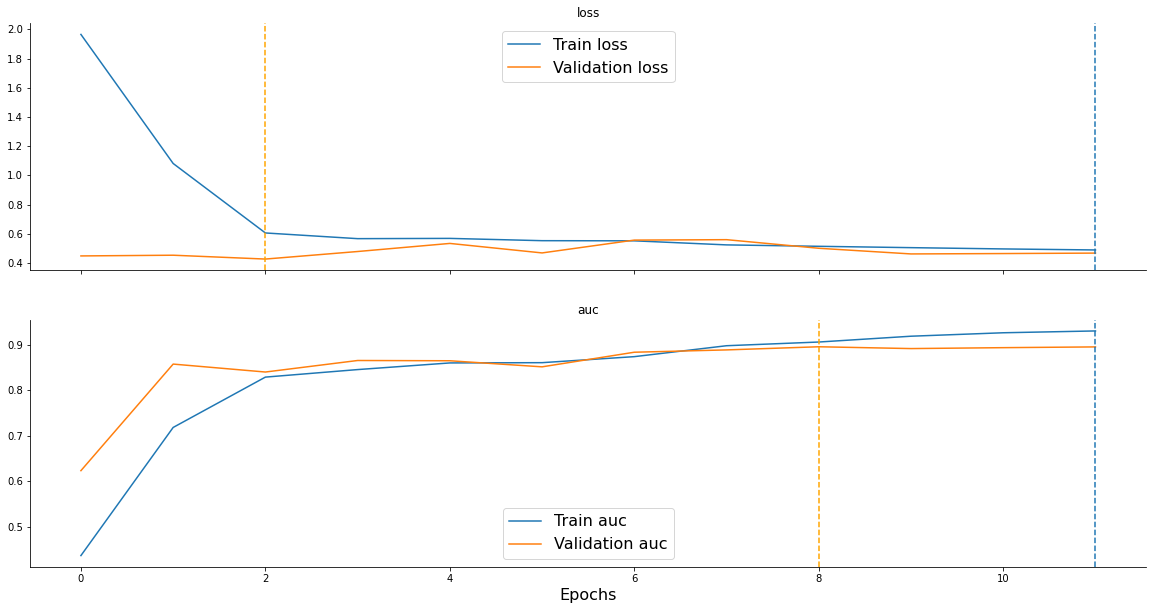

Fold: 2


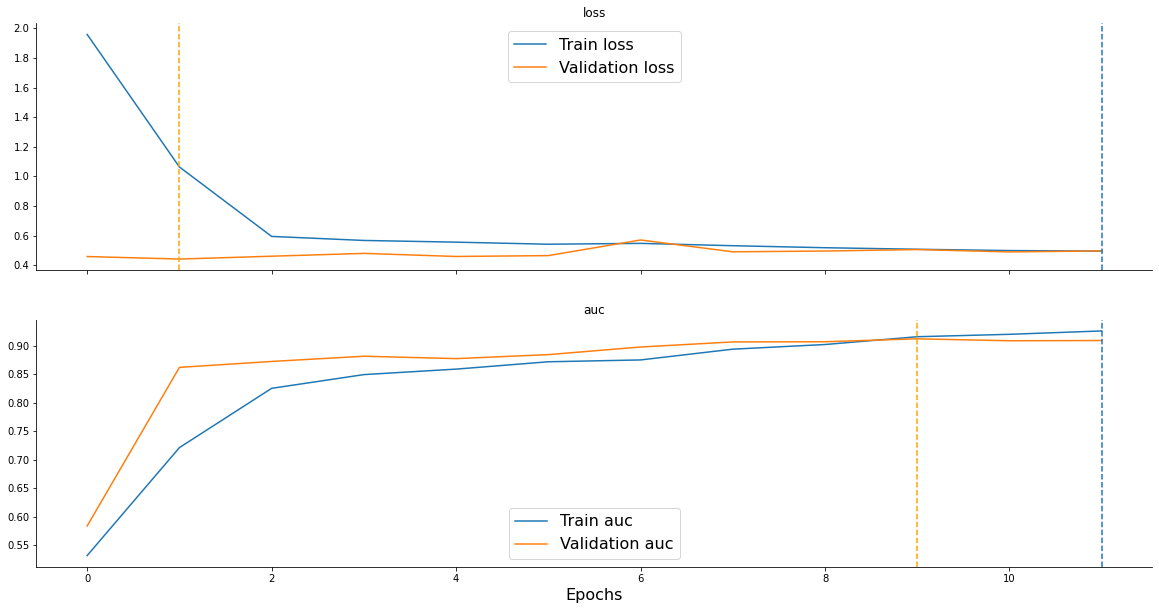

Fold: 3


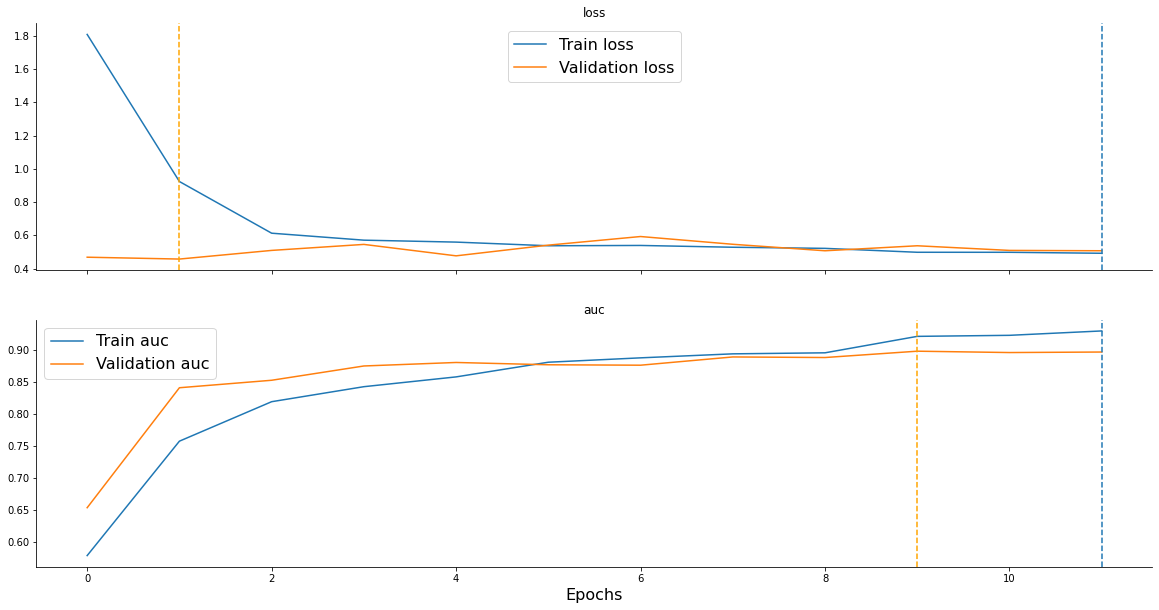

Fold: 4


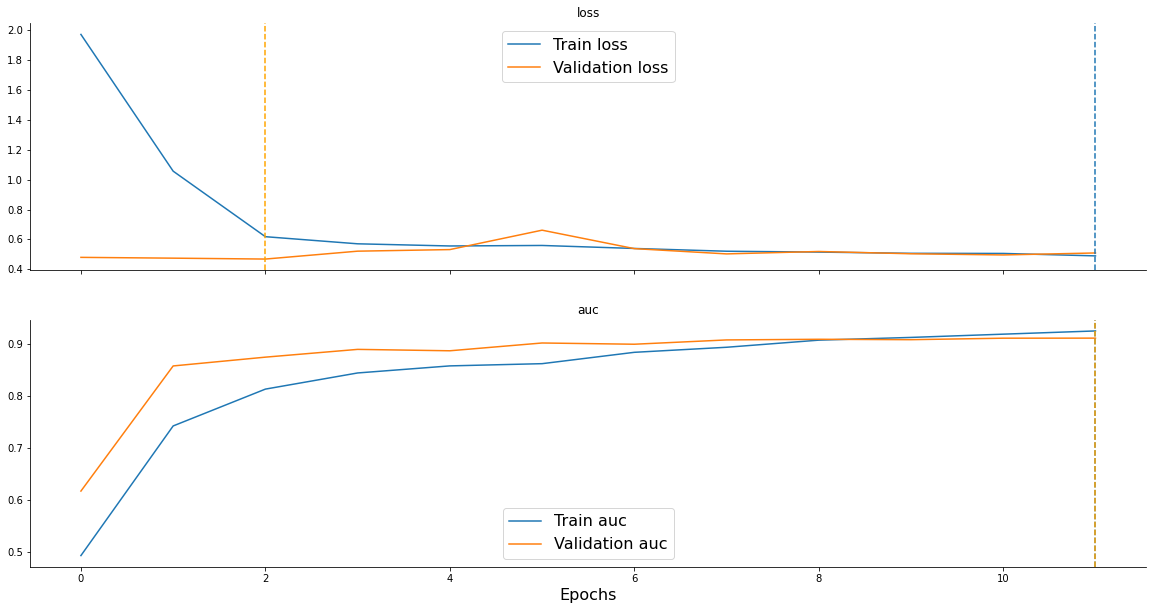

Fold: 5


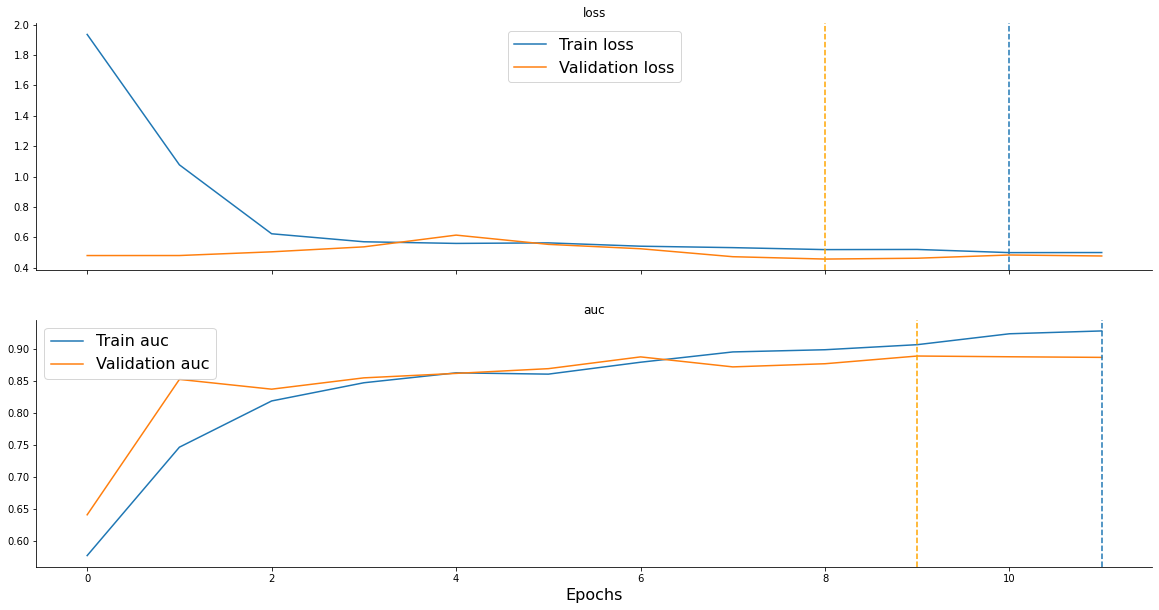

In [15]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

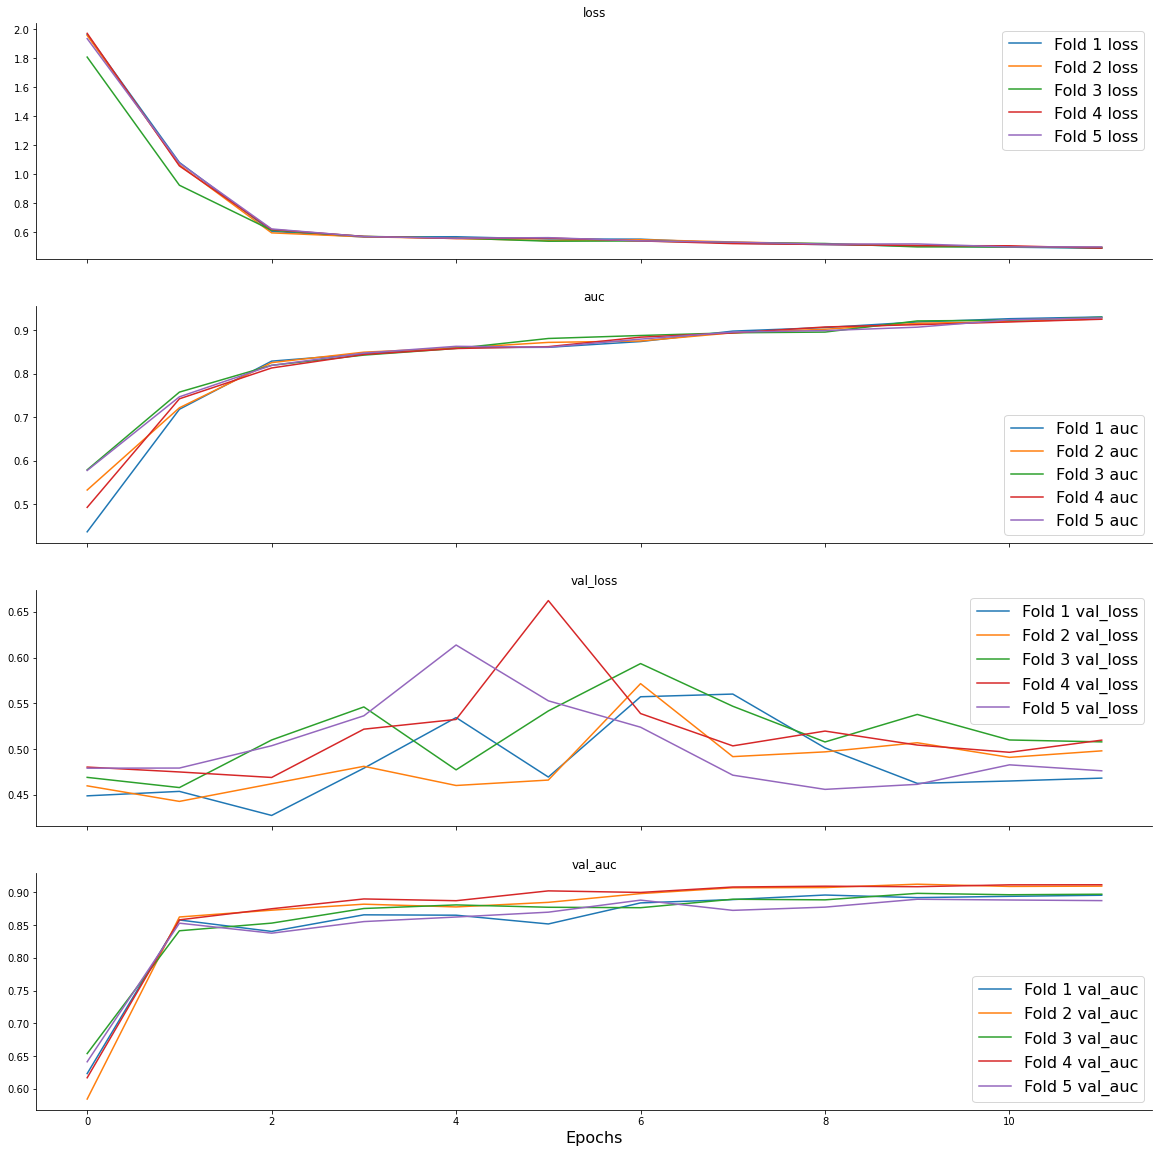

In [16]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (best)

In [17]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.963932,0.901653,0.062279,0.960471,0.895556,0.961612,0.912301,0.963923,0.898895,0.967428,0.911678,0.966226,0.889834
Accuracy,0.844826,0.834568,0.010258,0.834257,0.835857,0.842548,0.826354,0.821110,0.807111,0.845375,0.828536,0.880839,0.874981
Precision,0.100330,0.081315,0.019015,0.093678,0.077601,0.097179,0.081549,0.088028,0.072334,0.099150,0.082500,0.123615,0.092593
Recall,0.953115,0.796472,0.156643,0.957082,0.765217,0.948387,0.853448,0.969828,0.829060,0.956803,0.838983,0.933476,0.695652
F1-score,0.181270,0.147301,0.033969,0.170652,0.140913,0.176294,0.148872,0.161406,0.133059,0.179680,0.150228,0.218319,0.163432
Support,464.800000,116.200000,348.600000,466.000000,115.000000,465.000000,116.000000,464.000000,117.000000,463.000000,118.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.963932,0.901653,0.062279,0.960471,0.895556,0.961612,0.912301,0.963923,0.898895,0.967428,0.911678,0.966226,0.889834
male,0.963954,0.901458,0.062496,0.959242,0.903219,0.963175,0.892868,0.966133,0.890878,0.966098,0.918080,0.965121,0.902244
female,0.962472,0.897147,0.065325,0.960699,0.876807,0.958320,0.935314,0.959335,0.903938,0.967598,0.900841,0.966409,0.868832
head/neck,0.932814,0.826479,0.106335,0.941119,0.769571,0.927819,0.863804,0.920795,0.812130,0.940629,0.864294,0.933709,0.822597
upper extremity,0.963533,0.905156,0.058378,0.964519,0.888710,0.958964,0.911430,0.959810,0.900282,0.965712,0.931348,0.968661,0.894007
lower extremity,0.962924,0.881951,0.080972,0.956469,0.910533,0.961498,0.919594,0.958661,0.872019,0.972845,0.837152,0.965146,0.870459
torso,0.968474,0.920193,0.048280,0.963813,0.912869,0.967750,0.915249,0.972454,0.918715,0.968356,0.945750,0.969996,0.908383
0 <= age < 26,0.955752,0.845739,0.110012,0.955819,0.997085,0.964872,0.834382,0.946148,0.853168,0.953510,0.636555,0.958408,0.907509
26 <= age < 40,0.970032,0.887475,0.082557,0.969579,0.900109,0.959788,0.950369,0.965609,0.904637,0.975816,0.857484,0.979367,0.824777


# Model evaluation (last)

In [18]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.967437,0.900132,0.067304,0.966562,0.894626,0.965575,0.909321,0.967969,0.897302,0.967387,0.912291,0.969691,0.887122
Accuracy,0.857580,0.846995,0.010585,0.874479,0.873948,0.855156,0.843534,0.847355,0.827102,0.844992,0.829455,0.865919,0.860937
Precision,0.107611,0.084499,0.023112,0.118809,0.093929,0.105550,0.083026,0.100951,0.078073,0.099286,0.082915,0.113457,0.084551
Recall,0.955692,0.767131,0.188561,0.942060,0.713043,0.956989,0.775862,0.961207,0.803419,0.961123,0.838983,0.957082,0.704348
F1-score,0.193339,0.152040,0.041299,0.211007,0.165992,0.190130,0.150000,0.182712,0.142316,0.179980,0.150915,0.202866,0.150979
Support,464.800000,116.200000,348.600000,466.000000,115.000000,465.000000,116.000000,464.000000,117.000000,463.000000,118.000000,466.000000,115.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.967437,0.900132,0.067304,0.966562,0.894626,0.965575,0.909321,0.967969,0.897302,0.967387,0.912291,0.969691,0.887122
male,0.967338,0.899863,0.067475,0.964132,0.900848,0.966550,0.894949,0.970657,0.883192,0.966046,0.918833,0.969305,0.901493
female,0.966133,0.895722,0.070411,0.968546,0.878994,0.963044,0.926358,0.962552,0.908914,0.967518,0.901119,0.969006,0.863226
head/neck,0.937910,0.832936,0.104974,0.943747,0.766328,0.938982,0.870268,0.930049,0.838166,0.941247,0.867738,0.935525,0.822181
upper extremity,0.966653,0.906402,0.060251,0.969256,0.891743,0.961420,0.910332,0.965618,0.911924,0.965510,0.932333,0.971462,0.885678
lower extremity,0.968121,0.878254,0.089867,0.969007,0.914355,0.964145,0.903440,0.965415,0.866116,0.972620,0.838418,0.969420,0.868942
torso,0.971063,0.918825,0.052238,0.967338,0.916025,0.972024,0.913074,0.974419,0.910782,0.968442,0.945408,0.973095,0.908838
0 <= age < 26,0.959535,0.841307,0.118227,0.959902,0.997085,0.968993,0.817959,0.954824,0.855240,0.952640,0.647059,0.961315,0.889194
26 <= age < 40,0.973382,0.882744,0.090638,0.971393,0.903168,0.964495,0.944287,0.973467,0.889516,0.975873,0.858861,0.981682,0.817890


# Confusion matrix

Fold: 1


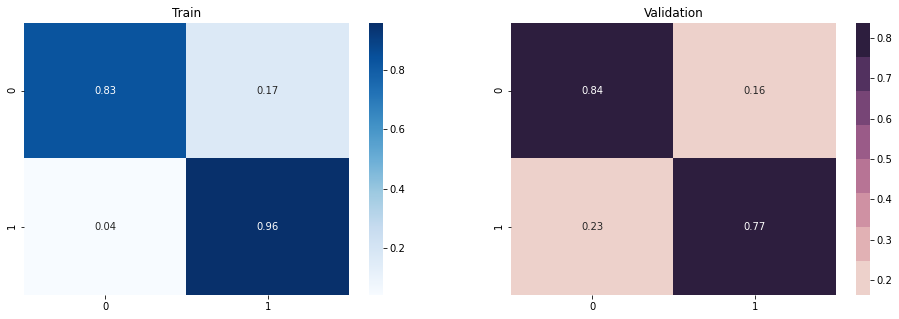

Fold: 2


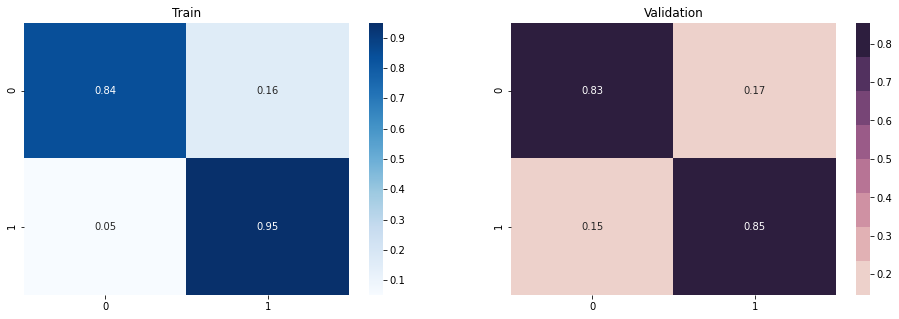

Fold: 3


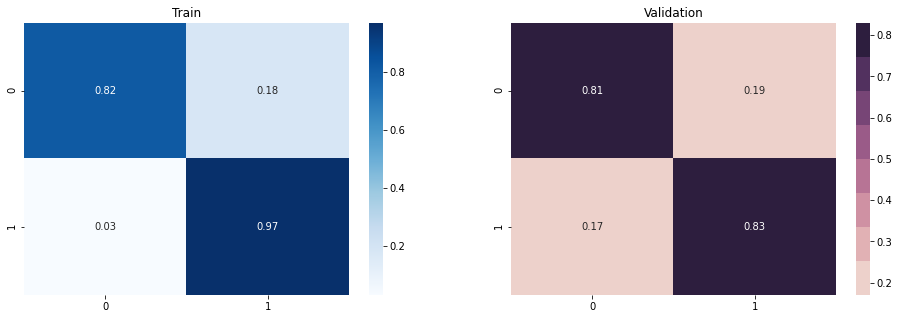

Fold: 4


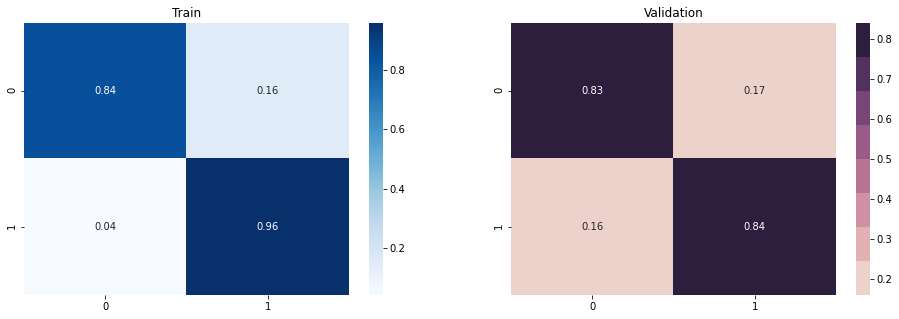

Fold: 5


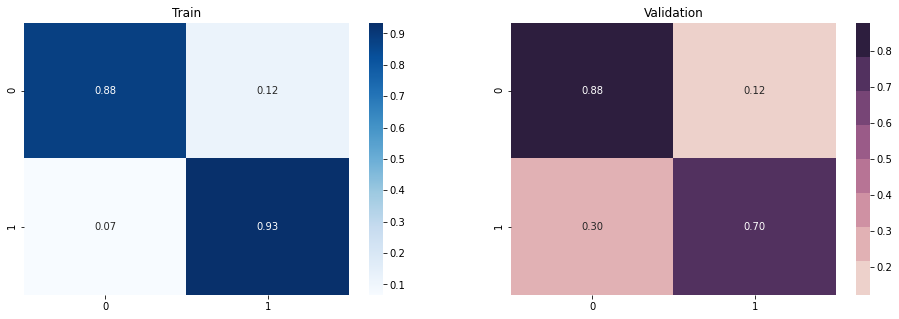

In [19]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [20]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 581
Train positive predictions: 5000
Train positive correct predictions: 552
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.396051,0.276201,0.271022,0.432584,0.522560,0.477889
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.059587,0.047055,0.044962,0.086170,0.044156,0.075592
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.080457,0.101298,0.096168,0.059367,0.091574,0.053879
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.390333,0.333576,0.462568,0.507473,0.372215,0.275833
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.036335,0.027901,0.049519,0.031985,0.035836,0.036436
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.099484,0.107348,0.081730,0.072341,0.094643,0.141358
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.210602,0.252050,0.167258,0.138835,0.252465,0.242400
7,ISIC_0075663,female,35.0,torso,unknown,0,0.416753,0.578993,0.453795,0.263081,0.392394,0.395503
8,ISIC_0075914,male,30.0,torso,unknown,0,0.101316,0.105257,0.091995,0.112137,0.110668,0.086524
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.132074,0.077527,0.117599,0.163460,0.152641,0.149144


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.297289,0.529012,0.310086,0.230540,0.312138,0.104671
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.776045,0.752676,0.798784,0.773316,0.856394,0.699055
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.740783,0.861423,0.558385,0.845229,0.594246,0.844631
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.695403,0.754190,0.674491,0.654111,0.713872,0.680353
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.660577,0.941073,0.890512,0.410071,0.572533,0.488694
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.852091,0.874325,0.897639,0.759780,0.866698,0.862016
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.848311,0.965268,0.452551,0.971532,0.940431,0.911774
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.771378,0.824288,0.802216,0.697257,0.913549,0.619577
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.727715,0.710148,0.844280,0.605867,0.831624,0.646659
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.793475,0.932413,0.647864,0.702534,0.782868,0.901694


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
10,ISIC_0076545,male,55.0,upper extremity,unknown,0,0.647441,0.581737,0.404925,0.782926,0.668647,0.798969
20,ISIC_0080817,male,50.0,lower extremity,unknown,0,0.621453,0.710772,0.757066,0.533649,0.528142,0.577634
48,ISIC_0092870,male,55.0,torso,unknown,0,0.770865,0.750261,0.677957,0.856991,0.835425,0.733689
65,ISIC_0105145,female,55.0,lower extremity,nevus,0,0.511107,0.365060,0.673377,0.579008,0.582612,0.355479
123,ISIC_0159060,male,55.0,head/neck,unknown,0,0.748129,0.759456,0.557495,0.702497,0.831615,0.889582
128,ISIC_0159996,female,60.0,head/neck,unknown,0,0.716949,0.715059,0.858779,0.604582,0.748797,0.657526
131,ISIC_0160455,male,75.0,lower extremity,nevus,0,0.672771,0.459455,0.784548,0.676429,0.749537,0.693889
136,ISIC_0162967,male,65.0,head/neck,unknown,0,0.581942,0.632059,0.469777,0.623382,0.720701,0.463790
145,ISIC_0164329,female,30.0,lower extremity,unknown,0,0.532449,0.347522,0.540395,0.560235,0.767946,0.446150
151,ISIC_0165449,male,60.0,torso,unknown,0,0.624567,0.590011,0.522613,0.754802,0.572487,0.682924


# Visualize test predictions

In [21]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last']
             + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 2368|8614
Test predictions (last) 2160|8822
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.091188,0.088683
1,ISIC_0052349,male,40.0,lower extremity,0.073244,0.062368
2,ISIC_0058510,female,55.0,torso,0.067737,0.063774
3,ISIC_0073313,female,50.0,torso,0.069204,0.062805
4,ISIC_0073502,female,45.0,lower extremity,0.432891,0.407181
5,ISIC_0074618,male,50.0,lower extremity,0.259544,0.240928
6,ISIC_0076801,male,45.0,upper extremity,0.200609,0.206457
7,ISIC_0077586,male,50.0,lower extremity,0.474587,0.453933
8,ISIC_0082004,female,45.0,torso,0.415508,0.382996
9,ISIC_0082785,male,65.0,lower extremity,0.309052,0.277122


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
14,ISIC_0090283,male,55.0,head/neck,0.520901,0.473286
18,ISIC_0097719,male,45.0,torso,0.593441,0.610630
19,ISIC_0099348,female,45.0,upper extremity,0.584160,0.578323
22,ISIC_0105104,male,40.0,torso,0.504641,0.523861
24,ISIC_0112420,female,65.0,torso,0.892336,0.886181
41,ISIC_0155813,male,55.0,lower extremity,0.686628,0.640303
42,ISIC_0155983,male,70.0,torso,0.903648,0.908881
45,ISIC_0161963,male,35.0,upper extremity,0.571741,0.541173
47,ISIC_0165230,female,35.0,torso,0.619462,0.630050
56,ISIC_0169906,male,85.0,torso,0.711564,0.729700


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
18,ISIC_0097719,male,45.0,torso,0.593441,0.610630
19,ISIC_0099348,female,45.0,upper extremity,0.584160,0.578323
22,ISIC_0105104,male,40.0,torso,0.504641,0.523861
24,ISIC_0112420,female,65.0,torso,0.892336,0.886181
41,ISIC_0155813,male,55.0,lower extremity,0.686628,0.640303
42,ISIC_0155983,male,70.0,torso,0.903648,0.908881
45,ISIC_0161963,male,35.0,upper extremity,0.571741,0.541173
47,ISIC_0165230,female,35.0,torso,0.619462,0.630050
56,ISIC_0169906,male,85.0,torso,0.711564,0.729700
57,ISIC_0171865,male,65.0,palms/soles,0.794292,0.797725


# Test set predictions

In [22]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend
0,ISIC_0052060,0.091188,0.088683,0.089936
1,ISIC_0052349,0.073244,0.062368,0.067806
2,ISIC_0058510,0.067737,0.063774,0.065756
3,ISIC_0073313,0.069204,0.062805,0.066004
4,ISIC_0073502,0.432891,0.407181,0.420036
5,ISIC_0074618,0.259544,0.240928,0.250236
6,ISIC_0076801,0.200609,0.206457,0.203533
7,ISIC_0077586,0.474587,0.453933,0.464260
8,ISIC_0082004,0.415508,0.382996,0.399252
9,ISIC_0082785,0.309052,0.277122,0.293087


,target,target_last,target_blend
count,10982.000000,10982.000000,10982.000000
mean,0.301043,0.286601,0.293822
std,0.224716,0.222306,0.223250
min,0.034907,0.034157,0.034532
25%,0.107523,0.099073,0.103643
50%,0.225692,0.205273,0.215742
75%,0.457838,0.432849,0.444839
max,0.955947,0.956881,0.956414
